In [1]:
# Clone the Diffusion-TS repository
!git clone https://github.com/Y-debug-sys/Diffusion-TS.git
%cd Diffusion-TS

# Install the required packages
!pip install -r requirements.txt

# Install the Diffusion-TS package
!pip install .


fatal: destination path 'Diffusion-TS' already exists and is not an empty directory.
/content/Diffusion-TS
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import csv

import yfinance as yf
from datetime import datetime, timedelta

from scipy.fft import fft
from prophet import Prophet
from prophet.serialize import model_to_json

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, \
    explained_variance_score, accuracy_score, precision_score


In [3]:
def get_delimiter(file_path, bytes=4096):
    """
    Retrieves the delimiter of a csv file.
    Args:
        file_path: path to csv file to read
        bytes: n bytes to read to detect the delimiter (higher is more guaranteed accuracy)

    Returns:
        delimiter: delimiter of the csv file located in the given path

    """
    sniffer = csv.Sniffer()
    data = open(file_path, "r").read(bytes)
    delimiter = sniffer.sniff(data).delimiter
    return delimiter

In [4]:
def query_yf(stock: tuple, period: int) -> pd.DataFrame:
    """
    Query the Yahoo Finance API for a given stock and store the data.

    :param stock: tuple
        A tuple containing three elements:
        - company (str): The name of the company.
        - ticker (str): The stock ticker symbol of the company.
        - exchange (str): The stock exchange where the company is listed.
    :param period: int
        The number of days of data to retrieve.

    :return: data: a pandas dataframe of the data
    """
    try:
        # Extract company, ticker, and exchange from the stock tuple
        company, ticker, exchange = stock

        yesterday = datetime.now() - timedelta(days=period)
        today = datetime.now()

        yesterday_str = yesterday.strftime('%Y-%m-%d')
        today_str = today.strftime('%Y-%m-%d')

        # Query the API using yfinance
        stock_data = yf.Ticker(ticker)
        data = stock_data.history(period='1d', start=yesterday_str, end=today_str)

        # Add the company name to the dataframe
        data['Company'] = company
        data['Ticker'] = ticker
        data['Exchange'] = exchange

        # Reorder the columns
        data = data[['Company', 'Ticker', 'Exchange', 'Open', 'High', 'Low', 'Close', 'Volume']]

        # Convert DataFrame index to a 'DatetimeIndex' without time zone information
        data.index = data.index.tz_localize(None)  # this is necessary for some algorithms

        return data
    except Exception as e:
        print(f"Error retrieving data: {e}")
        return None

In [5]:
def query_yf_list(stocks: pd.DataFrame, period: int) -> pd.DataFrame:
    """
    Query the Yahoo Finance API for all stocks in a list based on their exchange.

    :param stocks: list
        A list of tuples containing three elements:
        - company (str): The name of the company.
        - ticker (str): The stock ticker symbol of the company.
        - exchange (str): The stock exchange where the company is listed.
    :param period: int
        The number of days of data to retrieve.

    :return: data: a list of pandas dataframes of the data
    """
    # Create an empty list
    data = []

    # Loop through the list of stocks
    for _, row in stocks.iterrows():
        stock = (row['Company'], row['Ticker'], row['Stock Exchange'])

        # Query the API using yfinance
        stock_data = query_yf(stock, period)

        # Append the data to the dataframe
        if stock_data is not None:
            data.append(stock_data)

    return data

In [6]:
def save_stocks_to_csv(data_list: [pd.DataFrame], folder_path: str = "stock_data"):
    """
    Save a list of stock dataframes to a folder, each as a separate CSV file {company_name} data.csv.
    :param data_list: list of dataframes to save
    :param folder_path: folder path to save csvs to
    """
    try:
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        for df in data_list:
            df.reset_index(inplace=True)
            company = df.iloc[0]['Company']
            df.to_csv(os.path.join(folder_path, f"{company} data.csv"), index=None)
    except Exception as e:
        print(f"Error saving data: {e}")


In [16]:
# run this cell for querying using the stock list file
stocks_list = pd.read_csv('/content/Uranium Company Master List - Copy.csv')
periods = 365*5 # 3 years, however, some stocks only have 2022 to the present (was 5 years, need to conserve memory on my machine)
data_list = query_yf_list(stocks_list, periods)


In [17]:
data_list

[                              Company Ticker Exchange       Open       High  \
 Date                                                                          
 2019-12-04  Sprott Uranium Miners ETF   URNM     XNYS  11.108580  11.175744   
 2019-12-05  Sprott Uranium Miners ETF   URNM     XNYS  11.139511  11.294165   
 2019-12-06  Sprott Uranium Miners ETF   URNM     XNYS  11.320679  11.444401   
 2019-12-09  Sprott Uranium Miners ETF   URNM     XNYS  11.453239  11.453239   
 2019-12-10  Sprott Uranium Miners ETF   URNM     XNYS  11.196955  11.303004   
 ...                               ...    ...      ...        ...        ...   
 2024-08-02  Sprott Uranium Miners ETF   URNM     XNYS  42.220001  42.220001   
 2024-08-05  Sprott Uranium Miners ETF   URNM     XNYS  37.910000  40.035000   
 2024-08-06  Sprott Uranium Miners ETF   URNM     XNYS  40.000000  40.799999   
 2024-08-07  Sprott Uranium Miners ETF   URNM     XNYS  41.410000  41.599998   
 2024-08-08  Sprott Uranium Miners ETF  

In [18]:
save_stocks_to_csv(data_list)


In [19]:
import pandas as pd

# Load the data from your CSV file
input_file = '/content/Diffusion-TS/stock_data/Sprott Uranium Miners ETF data.csv'  # Replace with your input file name
df = pd.read_csv(input_file)

# Drop unnecessary columns
df_transformed = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Add the 'Adj_Close' column and set it equal to 'Close'
df_transformed['Adj_Close'] = df_transformed['Close']

# Reorder columns to match the desired format
df_transformed = df_transformed[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]

# Save the transformed data to a new CSV file
output_file = 'formatted_stock_data.csv'  # Replace with your desired output file name
df_transformed.to_csv(output_file, index=False)

print(f"Data has been transformed and saved to {output_file}")


Data has been transformed and saved to formatted_stock_data.csv


In [20]:
import zipfile
import os

# Define file paths
zip_file_path = '/content/datasets.zip'
destination_dir = '/content/Diffusion-TS/Data'

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)


In [14]:
import os

# Change to the /content/Diffusion-TS directory
os.chdir('/content/Diffusion-TS')


In [21]:
import shutil

# Specify the source and destination paths
source_path = '/content/Diffusion-TS/stock_data.csv'
destination_path = '/content/Diffusion-TS/Data/stock_data.csv'

# Move the file
shutil.move(source_path, destination_path)

print(f"File has been moved to {destination_path}")


File has been moved to /content/Diffusion-TS/Data/stock_data.csv


In [22]:
import shutil

# Specify the source and destination paths
source_path = '/content/Diffusion-TS/Data/stock_data.csv'
destination_path = '/content/Diffusion-TS/Data/datasets/stock_data.csv'

# Move the file
shutil.move(source_path, destination_path)

print(f"File has been moved to {destination_path}")


File has been moved to /content/Diffusion-TS/Data/datasets/stock_data.csv


In [23]:
!python main.py --name stock_data --config_file /content/Diffusion-TS/Config/stocks.yaml --gpu 0 --train




Global seed set to 12345
{'overall': {'trainable': '287.49K', 'non_trainable': '0', 'total': '287.49K'}, 'model': {'trainable': '287.49K', 'non_trainable': '0', 'total': '287.49K'}}
stock_data: start training...
loss: 0.079770: 100% 10000/10000 [11:03<00:00, 15.07it/s]
training complete
Training done, time: 663.59


In [24]:
!python /content/Diffusion-TS/main.py --name stock_data --config_file /content/Diffusion-TS/Config/stocks.yaml --gpu 0 --sample 1 --milestone 10 --mode predict --pred_len 50


Global seed set to 12345
{'overall': {'trainable': '287.49K', 'non_trainable': '0', 'total': '287.49K'}, 'model': {'trainable': '287.49K', 'non_trainable': '0', 'total': '287.49K'}}
Begin to restore...
conditional sampling loop time step: 100% 200/200 [00:10<00:00, 19.24it/s]
Imputation done, time: 10.40


In [25]:
import numpy as np

# Paths to the output files
ground_truth_test_path = '/content/Diffusion-TS/OUTPUT/stock_data/samples/stock_ground_truth_24_test.npy'
ground_truth_train_path = '/content/Diffusion-TS/OUTPUT/stock_data/samples/stock_ground_truth_24_train.npy'
norm_truth_test_path = '/content/Diffusion-TS/OUTPUT/stock_data/samples/stock_norm_truth_24_test.npy'
norm_truth_train_path = '/content/Diffusion-TS/OUTPUT/stock_data/samples/stock_norm_truth_24_train.npy'
predicted_path = '/content/Diffusion-TS/OUTPUT/stock_data/ddpm_predict_stock_data.npy'

# Load the .npy files
ground_truth_test = np.load(ground_truth_test_path)
ground_truth_train = np.load(ground_truth_train_path)
norm_truth_test = np.load(norm_truth_test_path)
norm_truth_train = np.load(norm_truth_train_path)
predicted = np.load(predicted_path)


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Ensure that the shapes of the ground truth and predicted arrays match
assert norm_truth_test.shape == predicted.shape, "Shapes of ground truth and predicted arrays do not match."

# Flatten the arrays to make sure they are 1-dimensional for metric calculations
norm_truth_test_flat = norm_truth_test.flatten()
predicted_flat = predicted.flatten()

# Calculate metrics
mse = mean_squared_error(norm_truth_test_flat, predicted_flat)
mae = mean_absolute_error(norm_truth_test_flat, predicted_flat)
rmse = mean_squared_error(norm_truth_test_flat, predicted_flat, squared=False)
r2 = r2_score(norm_truth_test_flat, predicted_flat)
mape = mean_absolute_percentage_error(norm_truth_test_flat, predicted_flat)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')


Mean Squared Error (MSE): 0.09875752794586139
Mean Absolute Error (MAE): 0.23521821941195692
Root Mean Squared Error (RMSE): 0.3142571048454774
R-squared (R²): -0.38843338907979885
Mean Absolute Percentage Error (MAPE): 1974391983188.9934


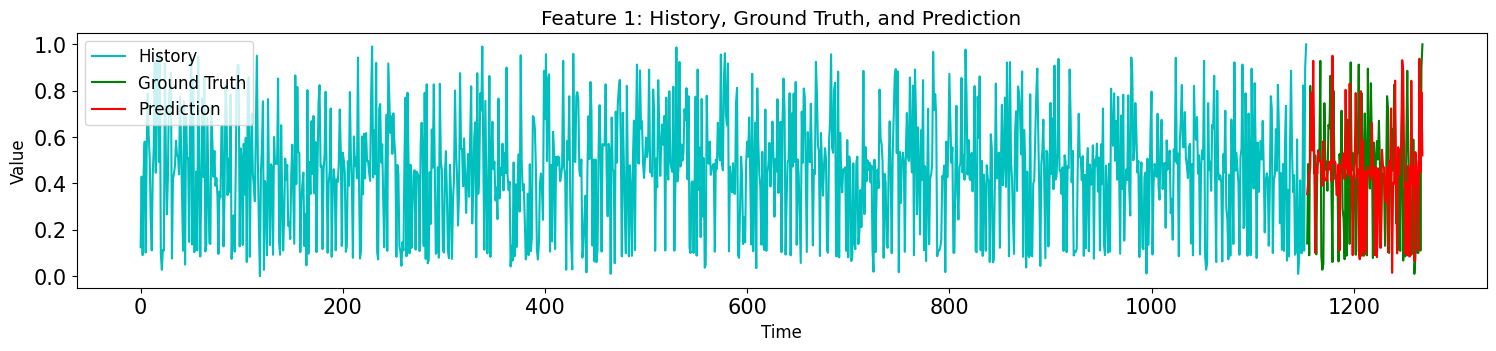

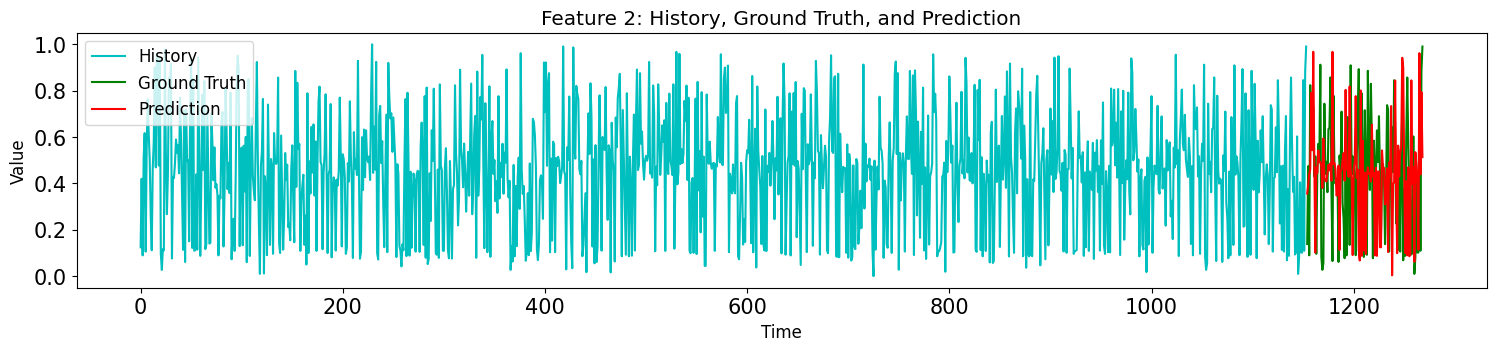

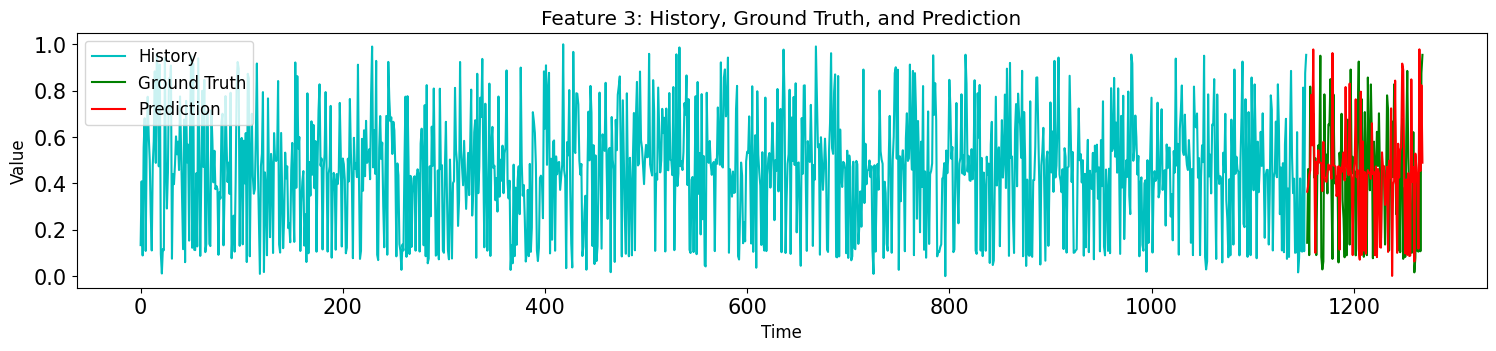

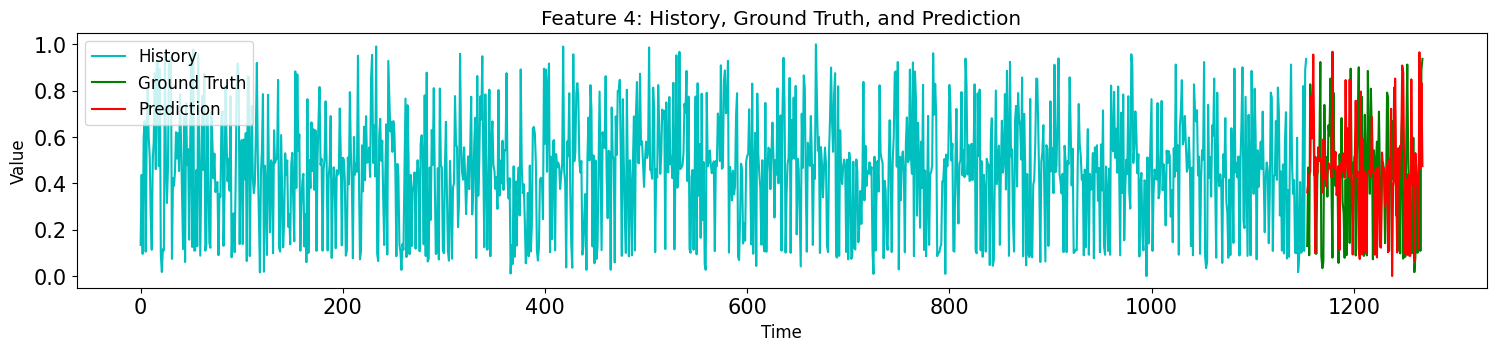

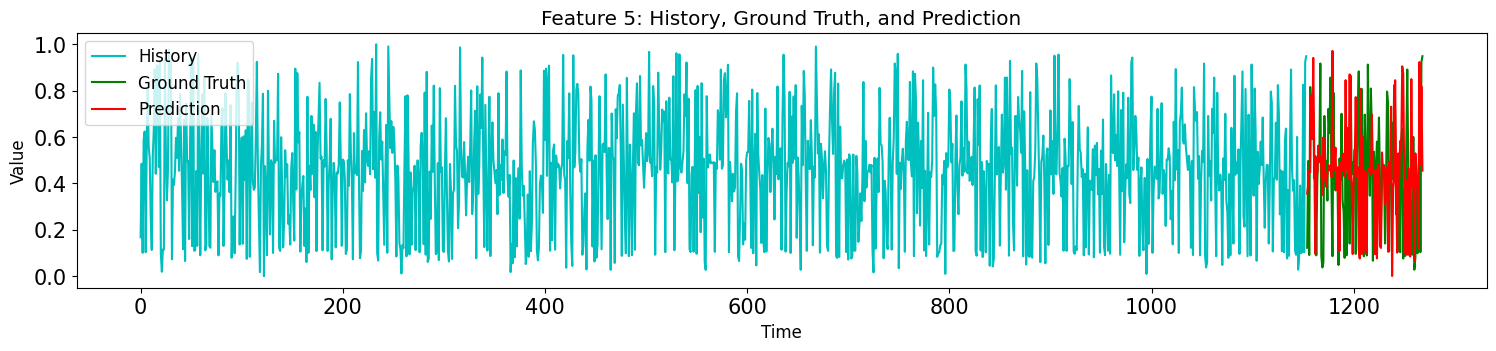

In [27]:
import matplotlib.pyplot as plt

# Concatenate train and test along the time axis
norm_truth_combined = np.concatenate((norm_truth_train, norm_truth_test), axis=0)

# Define sequence length and prediction length
seq_length = norm_truth_combined.shape[0]
pred_length = predicted.shape[0]

# Ensure the ranges match
x_history = range(seq_length - pred_length)  # History range
x_ground_truth = range(seq_length - pred_length, seq_length)  # Ground truth and prediction range

# Plotting
plt.rcParams["font.size"] = 12

for idx in range(min(5, predicted.shape[2])):  # Ensure idx is within the feature dimension range
    plt.figure(figsize=(15, 3))

    # Plot the historical data
    plt.plot(x_history, norm_truth_combined[:seq_length - pred_length, idx, 0], color='c', linestyle='solid', label='History')

    # Plot the actual ground truth for the prediction period
    plt.plot(x_ground_truth, norm_truth_combined[-pred_length:, idx, 0], color='g', linestyle='solid', label='Ground Truth')

    # Plot the prediction
    plt.plot(x_ground_truth, predicted[:, idx, 0], color='r', linestyle='solid', label='Prediction')

    plt.tick_params('both', labelsize=15)
    plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
    plt.legend()
    plt.title(f'Feature {idx + 1}: History, Ground Truth, and Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

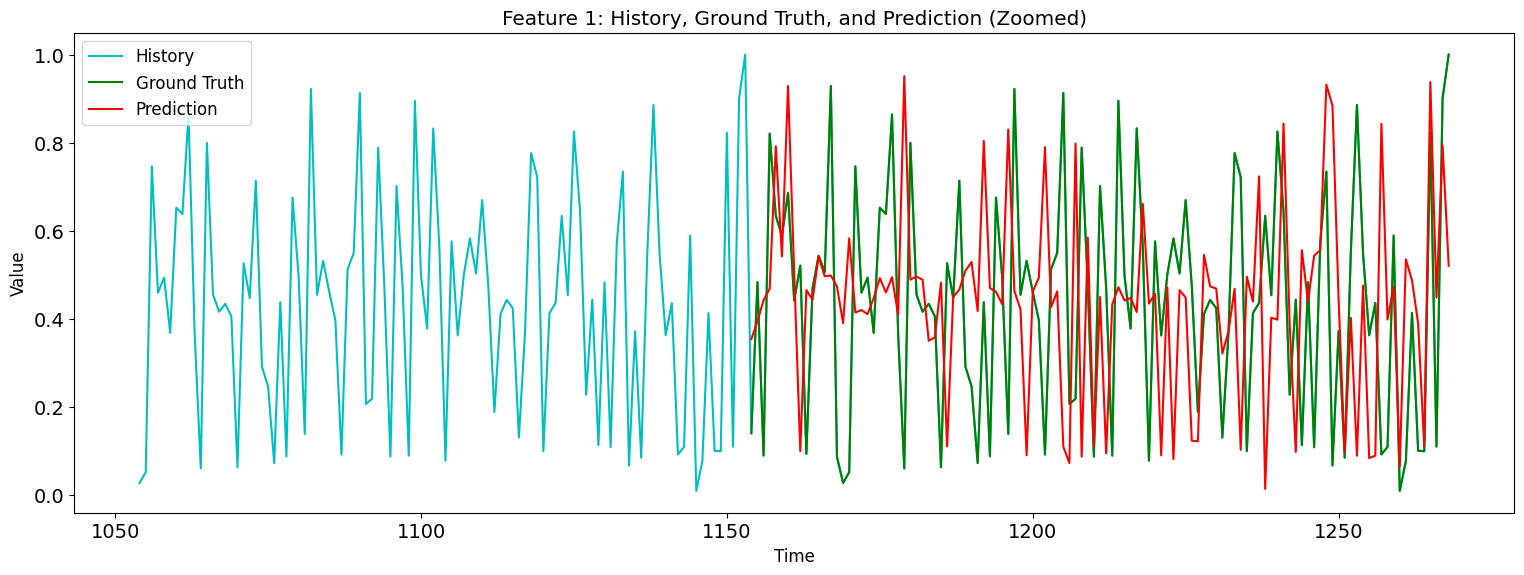

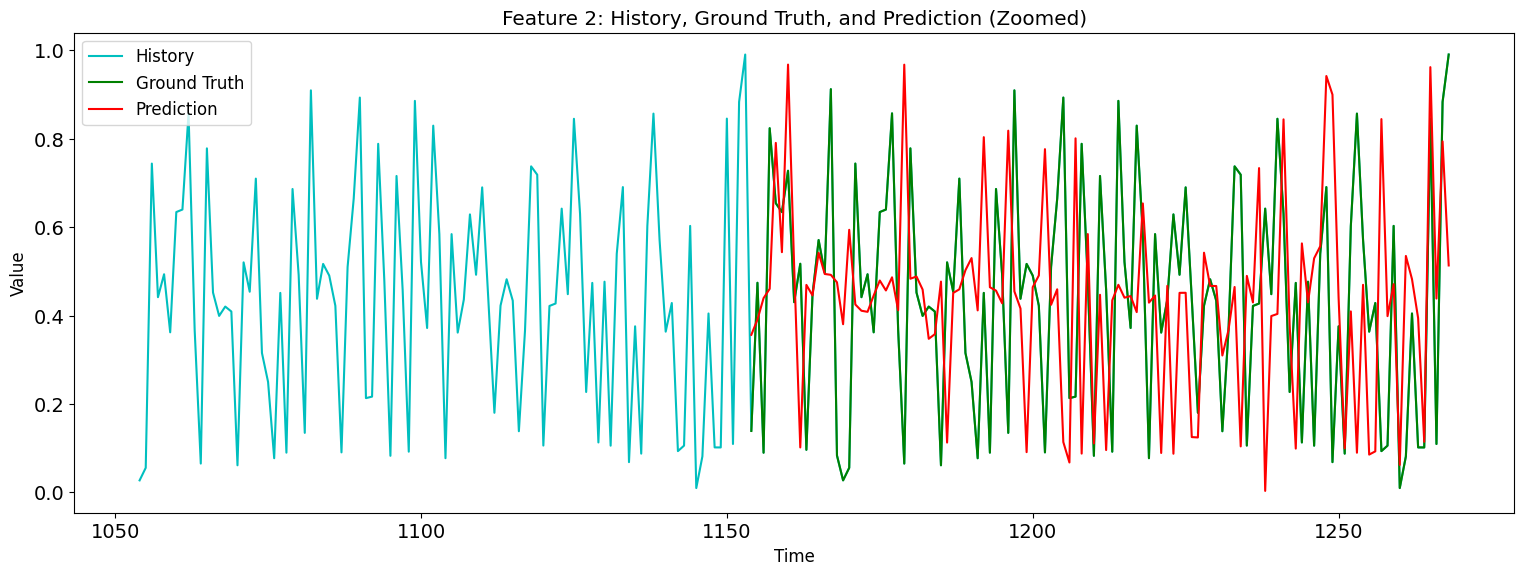

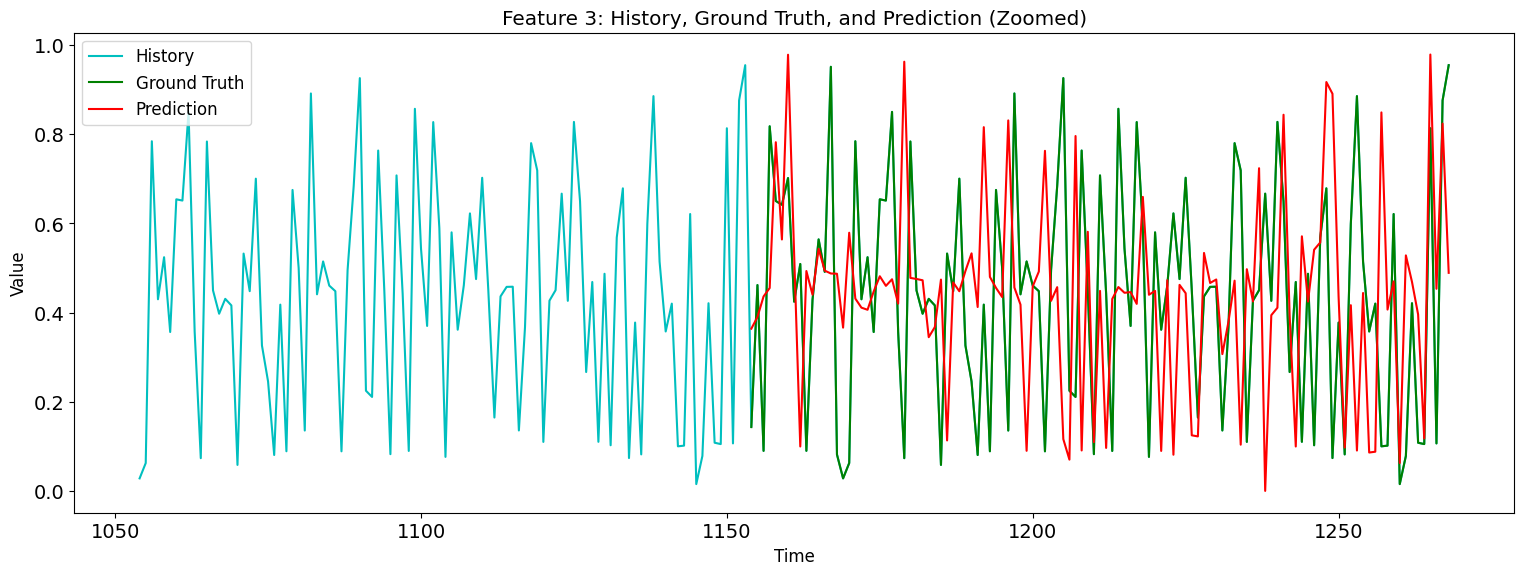

In [28]:
# Concatenate train and test along the time axis
norm_truth_combined = np.concatenate((norm_truth_train, norm_truth_test), axis=0)

# Define sequence length and prediction length
seq_length = norm_truth_combined.shape[0]
pred_length = predicted.shape[0]

# Number of features to plot
num_features_to_plot = 3  # Adjust this number to plot fewer features

# Zoom into the last part of the data
zoom_start = seq_length - pred_length - 100  # Adjust this to zoom further in or out
zoom_end = seq_length  # End at the last data point

# Plot each feature separately to reduce clutter
for idx in range(min(num_features_to_plot, predicted.shape[2])):  # Ensure idx is within the feature dimension range
    plt.figure(figsize=(18, 6))  # Increase figure size

    # Plot the historical data
    plt.plot(range(zoom_start, zoom_end), norm_truth_combined[zoom_start:zoom_end, idx, 0], color='c', linestyle='solid', label='History')

    # Plot the actual ground truth for the prediction period
    plt.plot(range(zoom_end - pred_length, zoom_end), norm_truth_combined[-pred_length:, idx, 0], color='g', linestyle='solid', label='Ground Truth')

    # Plot the prediction
    plt.plot(range(zoom_end - pred_length, zoom_end), predicted[:, idx, 0], color='r', linestyle='solid', label='Prediction')

    plt.tick_params('both', labelsize=14)
    plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.9)  # Adjust subplot spacing
    plt.legend()
    plt.title(f'Feature {idx + 1}: History, Ground Truth, and Prediction (Zoomed)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()